In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Double-well problem

Consider the following stochastic differential equations,

dxt = −∇xV (xt, yt) dt + σ dwt1

dyt = −∇yV (xt, yt) dt + σ dwt2

where wt1 and wt2 are two independent standard Wiener processes. In this example, the potential is given by V (x, y) = (x^2 − 1)^2 + y^2 and σ = 0.7. Numerically, this system can be solved using the Euler–Maruyama method, which, for an SDE of the form

dxt = µ(t, xt) dt + σ(t, xt) dwt, can be written as


xk+1 = xk + h µ(tk, xk) + σ(tk, xk) ∆wk,


where h is the step size and ∆wk = wk+1 −wk ∼ N (0, h). Here, N (0, h) denotes a normal distribution with mean 0
and variance h. 

## Simulating a typical trajectory of the system using EM method

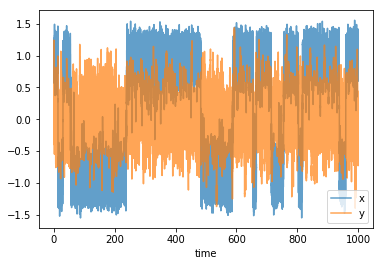

In [5]:
def iterate_x(h, x, y, sigma):
    # gaussian distribution with mean 0 and variance h
    w = np.random.normal(0, np.sqrt(h), 1)
    # found by differentiating example
    x_new = x - h*(4*(x**3) - 4*x) + sigma*w
    return x_new


def iterate_y(h, x, y, sigma):
    # gaussian distribution with mean 0 and variance h
    w = np.random.normal(0, np.sqrt(h), 1)
    y_new = y - h*(2*y) + sigma*w
    return y_new


num_iterations = 10**6

x_trajectory = np.zeros(num_iterations)
y_trajectory = np.zeros(num_iterations)

# initial conditions
x = 1.0
y = 1.0
h = 0.001  # this is the step size
sigma = 0.7

for i in range(num_iterations):
    x = iterate_x(h, x, y, sigma)
    y = iterate_y(h, x, y, sigma)

    x_trajectory[i] = x
    y_trajectory[i] = y


time = [h*i for i in range(num_iterations)]

plt.plot(time, x_trajectory, alpha=0.7, label='x')
plt.plot(time, y_trajectory, alpha=0.7, label='y')

plt.xlabel('time')
plt.legend()
plt.show()

as can be seen the x variable typically stays for a long time close to
x = −1 or x = 1 and rarely switches from one state to the other. The y variable oscillates around the equilibrium
y = 0

## Using Ulam's method to approximate the Frobenius-Perron operator

See https://arxiv.org/pdf/1512.05997.pdf or https://www.sciencedirect.com/science/article/pii/0167278995002928 for details

In [ ]:
# create boxes in x, y plane between -2 and 2. This can be established in a 2d matrix

# partitioned the domain Ω = [−2, 2]^2 into 50×50 boxes of the same size

num_intervals = 50
num_boxes = 50**2

max_val = 2
min_val = -2

x_intervals = np.arange(min_val, max_val, (max_val - min_val)/num_intervals)
y_intervals = np.arange(min_val, max_val, (max_val - min_val)/num_intervals)

indicator_matrix = [[0 for x in range(num_boxes)] for y in range(num_boxes)]


# pick x points (picked uniformly) in each box and run for x number of iterations. See which box Bj it goes to
# as well as the box it comes from on previous iteration Bi. Update indicator_matrix[Bi][Bj] += 1

num_simulated_points = 100
num_iterations = 100

# intial conditions
h = 0.001  # this is the step size
sigma = 0.7

X = []  # just for plotting at end
Y = []


for idx_x, val_x in enumerate(x_intervals):
    for idx_y, val_y in enumerate(y_intervals):
        X.append(val_x)
        Y.append(val_y)
        for _ in range(num_simulated_points):
            if idx_x != num_intervals - 1:
                x_init = np.random.uniform(val_x, x_intervals[idx_x + 1])
            else:
                x_init = np.random.uniform(val_x, max_val)

            if idx_y != num_intervals - 1:
                y_init = np.random.uniform(val_y, y_intervals[idx_y + 1])
            else:
                y_init = np.random.uniform(val_y, max_val)

            x_new = iterate_x(h, x_init, y_init, sigma)
            y_new = iterate_y(h, x_init, y_init, sigma)
            indicator_matrix[int(idx_x*num_intervals + idx_y)
                             ][int((x_place[0] - 1)*num_intervals + (y_place[0] - 1))] += 1

            for _ in range(num_iterations):
                x_init = x_new
                y_init = y_new

                x_place_init = np.searchsorted(x_intervals, x_init)
                y_place_init = np.searchsorted(y_intervals, y_init)

                x_new = iterate_x(h, x_init, y_init, sigma)
                y_new = iterate_y(h, x_init, y_init, sigma)

                x_place = np.searchsorted(x_intervals, x_new)
                y_place = np.searchsorted(y_intervals, y_new)

                indicator_matrix[int((x_place_init[0] - 1)*num_intervals + (y_place_init[0] - 1))
                                 ][int((x_place[0] - 1)*num_intervals + (y_place[0] - 1))] += 1

In [ ]:
indicator_matrix_array = np.array(indicator_matrix)
row_sums = indicator_matrix_array.sum(axis=1)
normalised_matrix = indicator_matrix_array / row_sums[:, np.newaxis]
eigenvalues, eigenvectors = np.linalg.eig(normalised_matrix)
rearrangedEvalsVecs = sorted(zip(eigenvalues, eigenvectors.T),
                             key=lambda x: x[0].real, reverse=True)


eigenvalue_index = 0

eigen_explored = rearrangedEvalsVecs[eigenvalue_index][1]

X = []
Y = []

for idx_x, val_x in enumerate(x_intervals):
    for idx_y, val_y in enumerate(y_intervals):
        X.append(val_x)
        Y.append(val_y)


X = np.asarray(X)
Y = np.asarray(Y)
X = X.reshape(50, 50)
Y = Y.reshape(50, 50)
Z = eigen_explored.reshape(50, 50)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(X, Y, Z)
plt.show()